In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread

import warnings
warnings.filterwarnings("ignore")
import torch 
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
input_image = imread('/content/image_R_1_001.png', as_gray=True)
input_image = input_image/255.0
input_image = input_image - 0.5

target_image = imread('/content/image_R_1_avg50.png', as_gray=True)
target_image = target_image/255.0
target_image = target_image - 0.5

In [9]:
import torch
import torch.nn as nn

def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)

class UpsamplingNearest2d(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        self.scale_factor = scale_factor
    
    def forward(self, x):
        return nn.functional.interpolate(x, scale_factor=self.scale_factor, mode='nearest')

class UnetN2N(nn.Module):
    """https://github.com/NVlabs/noise2noise
    Lehtinen, Jaakko, et al. "Noise2Noise: Learning Image Restoration without 
    Clean Data." arXiv preprint arXiv:1803.04189 (2018).
    """
    def __init__(self, in_channels, out_channels):
        super(UnetN2N, self).__init__()

        self.enc_conv0 = conv3x3(in_channels, 48)
        self.enc_relu0 = nn.LeakyReLU(0.1)
        self.enc_conv1 = conv3x3(48, 48)
        self.enc_relu1 = nn.LeakyReLU(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 128
        self.enc_conv2 = conv3x3(48, 48)
        self.enc_relu2 = nn.LeakyReLU(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # 64
        self.enc_conv3 = conv3x3(48, 48)
        self.enc_relu3 = nn.LeakyReLU(0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        # 32
        self.enc_conv4 = conv3x3(48, 48)
        self.enc_relu4 = nn.LeakyReLU(0.1)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        # 16
        self.enc_conv5 = conv3x3(48, 48)
        self.enc_relu5 = nn.LeakyReLU(0.1)
        self.pool5 = nn.MaxPool2d(kernel_size=2)
        # 8
        self.enc_conv6 = conv3x3(48, 48)
        self.enc_relu6 = nn.LeakyReLU(0.1)
        self.upsample5 = UpsamplingNearest2d(scale_factor=2)
        # 16
        self.dec_conv5a = conv3x3(96, 96)
        self.dec_relu5a = nn.LeakyReLU(0.1)
        self.dec_conv5b = conv3x3(96, 96)
        self.dec_relu5b = nn.LeakyReLU(0.1)
        self.upsample4 = UpsamplingNearest2d(scale_factor=2)
        # 32
        self.dec_conv4a = conv3x3(144, 96)
        self.dec_relu4a = nn.LeakyReLU(0.1)
        self.dec_conv4b = conv3x3(96, 96)
        self.dec_relu4b = nn.LeakyReLU(0.1)
        self.upsample3 = UpsamplingNearest2d(scale_factor=2)
        # 64
        self.dec_conv3a = conv3x3(144, 96)
        self.dec_relu3a = nn.LeakyReLU(0.1)
        self.dec_conv3b = conv3x3(96, 96)
        self.dec_relu3b = nn.LeakyReLU(0.1)
        self.upsample2 = UpsamplingNearest2d(scale_factor=2)
        # 128
        self.dec_conv2a = conv3x3(144, 96)
        self.dec_relu2a = nn.LeakyReLU(0.1)
        self.dec_conv2b = conv3x3(96, 96)
        self.dec_relu2b = nn.LeakyReLU(0.1)
        self.upsample1 = UpsamplingNearest2d(scale_factor=2)
        # 256
        self.dec_conv1a = conv3x3(96 + in_channels, 64)
        self.dec_relu1a = nn.LeakyReLU(0.1)
        self.dec_conv1b = conv3x3(64, 32)
        self.dec_relu1b = nn.LeakyReLU(0.1)
        self.dec_conv1c = conv3x3(32, out_channels)

    def forward(self, x):
        out_pool1 = self.pool1(self.enc_relu1(self.enc_conv1(self.enc_relu0(self.enc_conv0(x)))))
        out_pool2 = self.pool2(self.enc_relu2(self.enc_conv2(out_pool1)))
        out_pool3 = self.pool3(self.enc_relu3(self.enc_conv3(out_pool2)))
        out_pool4 = self.pool4(self.enc_relu4(self.enc_conv4(out_pool3)))
        out_pool5 = self.pool5(self.enc_relu5(self.enc_conv5(out_pool4)))
        out = self.upsample5(self.enc_relu6(self.enc_conv6(out_pool5)))
        out = self.upsample4(self.dec_relu5b(self.dec_conv5b(self.dec_relu5a(self.dec_conv5a(torch.cat((out, out_pool4), 1))))))
        out = self.upsample3(self.dec_relu4b(self.dec_conv4b(self.dec_relu4a(self.dec_conv4a(torch.cat((out, out_pool3), 1))))))
        out = self.upsample2(self.dec_relu3b(self.dec_conv3b(self.dec_relu3a(self.dec_conv3a(torch.cat((out, out_pool2), 1))))))
        out = self.upsample1(self.dec_relu2b(self.dec_conv2b(self.dec_relu2a(self.dec_conv2a(torch.cat((out, out_pool1), 1))))))
        out = self.dec_conv1c(self.dec_relu1b(self.dec_conv1b(self.dec_relu1a(self.dec_conv1a(torch.cat((out, x), 1))))))
        return [out_pool1, out_pool2, out_pool3, out_pool4, out_pool5, out]
 
    @property
    def model_size(self):
        return self._model_size()

    def _model_size(self):
        n_params, n_conv_layers = 0, 0
        for param in self.parameters():
            n_params += param.numel()
        for module in self.modules():
            if 'Conv' in module.__class__.__name__ \
                    or 'conv' in module.__class__.__name__:
                n_conv_layers += 1
        return n_params, n_conv_layers

In [10]:
model = UnetN2N(1, 1)
#print(model)
#print(model.model_size)
model.load_state_dict(torch.load('/content/model_epoch200.pth', map_location='cpu'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

UnetN2N(
  (enc_conv0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (enc_relu0): LeakyReLU(negative_slope=0.1)
  (enc_conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (enc_relu1): LeakyReLU(negative_slope=0.1)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (enc_relu2): LeakyReLU(negative_slope=0.1)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (enc_relu3): LeakyReLU(negative_slope=0.1)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (enc_relu4): LeakyReLU(negative_slope=0.1)
  (pool4): MaxPool2d(kernel_size=2, stride=2

In [11]:
import numpy as np
from PIL import Image
import torch
import numpy as np
import torch.nn.functional as F
#from skimage.measure import compare_psnr, compare_ssim
import torch
import numpy as np
import os

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        if input.requires_grad:
            input = input.detach()
        return input.cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def mkdirs(paths):
    if isinstance(paths, list) and not isinstance(paths, str):
        for path in paths:
            mkdir(path)
    else:
        mkdir(paths)

def cal_psnr(clean, noisy, max_val=255, normalized=True):
    """
    Args:
        clean (Tensor): [0, 255], BCHW
        noisy (Tensor): [0, 255], BCHW
        normalized (bool): If True, the range of tensors are [-0.5 , 0.5]
            else [0, 255]
    Returns:
        PSNR per image: (B,)
    """
    if normalized:
        clean = clean.add(0.5).mul(255).clamp(0, 255)
        noisy = noisy.add(0.5).mul(255).clamp(0, 255)
    mse = F.mse_loss(noisy, clean, reduction='none').view(clean.shape[0], -1).mean(1)
    return 10 * torch.log10(max_val ** 2 / mse)


def cal_ssim(clean, noisy, normalized=True):
    """Use skimage.meamsure.compare_ssim to calculate SSIM
    Args:
        clean (Tensor): (B, 1, H, W)
        noisy (Tensor): (B, 1, H, W)
        normalized (bool): If True, the range of tensors are [-0.5 , 0.5]
            else [0, 255]
    Returns:
        SSIM per image: (B, )
    """
    if normalized:
        clean = clean.add(0.5).mul(255).clamp(0, 255)
        noisy = noisy.add(0.5).mul(255).clamp(0, 255)

    clean, noisy = to_numpy(clean), to_numpy(noisy)
    ssim = np.array([compare_ssim(clean[i, 0], noisy[i, 0], data_range=255) 
        for i in range(clean.shape[0])])

    return ssim   


def cal_psnr2(clean, noisy, normalized=True):
    """Use skimage.meamsure.compare_ssim to calculate SSIM
    Args:
        clean (Tensor): (B, 1, H, W)
        noisy (Tensor): (B, 1, H, W)
        normalized (bool): If True, the range of tensors are [-0.5 , 0.5]
            else [0, 255]
    Returns:
        SSIM per image: (B, )
    """
    if normalized:
        clean = clean.add(0.5).mul(255).clamp(0, 255)
        noisy = noisy.add(0.5).mul(255).clamp(0, 255)

    clean, noisy = to_numpy(clean), to_numpy(noisy)

    psnr = np.array([compare_psnr(clean[i, 0], noisy[i, 0], data_range=255) 
        for i in range(clean.shape[0])])

    return psnr   

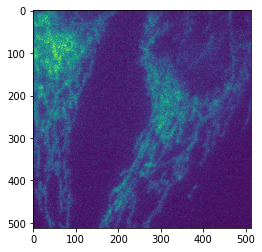

In [37]:
input_image2 = imread('/content/input_avg1_010_0.tif', as_gray=True)
input_image2 = input_image2/255.0
input_image2 = input_image2 - 0.5
imshow(input_image2)

input_image2_torch = torch.tensor(input_image2)
input_image2_torch = torch.unsqueeze(input_image2_torch, 0)
input_image2_torch = torch.unsqueeze(input_image2_torch, 0)
input_image2_torch = input_image2_torch.float()
input_image2_torch = input_image2_torch.to(device)

Output shape values here:  [torch.Size([1, 48, 256, 256]), torch.Size([1, 48, 128, 128]), torch.Size([1, 48, 64, 64]), torch.Size([1, 48, 32, 32]), torch.Size([1, 48, 16, 16]), torch.Size([1, 1, 512, 512])]


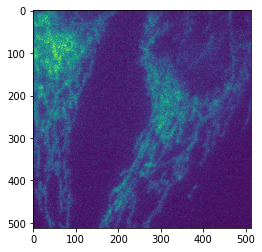

In [45]:
from matplotlib.pyplot import imshow
%matplotlib inline
#image is a numpy array
imshow(input_image2)
input_image_torch = torch.tensor(input_image)
input_image_torch = torch.unsqueeze(input_image_torch, 0)
input_image_torch = torch.unsqueeze(input_image_torch, 0)
input_image_torch = input_image_torch.float()
input_image_torch = input_image_torch.to(device)

target_image_torch = torch.tensor(target_image)
target_image_torch = torch.unsqueeze(target_image_torch, 0)
target_image_torch = torch.unsqueeze(target_image_torch, 0)
target_image_torch = target_image_torch.float()
target_image_torch = target_image_torch.to(device) 
#print(input_image_torch)
#FMD image
#[denoised_l1, denoised_l2, denoised_l3, denoised_l4, denoised_l5, denoised_last] = model(input_image_torch)
#W2S image
[denoised_l1, denoised_l2, denoised_l3, denoised_l4, denoised_l5, denoised_last] = model(input_image2_torch)


print('Output shape values here: ',[denoised_l1.shape, denoised_l2.shape, denoised_l3.shape, denoised_l4.shape, denoised_l5.shape, denoised_last.shape])
#print('PSNR values:',cal_psnr(target_image_torch, input_image_torch),cal_psnr(target_image_torch, denoised))
#print('SSIM values:',cal_ssim(target_image_torch, input_image_torch),cal_ssim(target_image_torch, denoised))

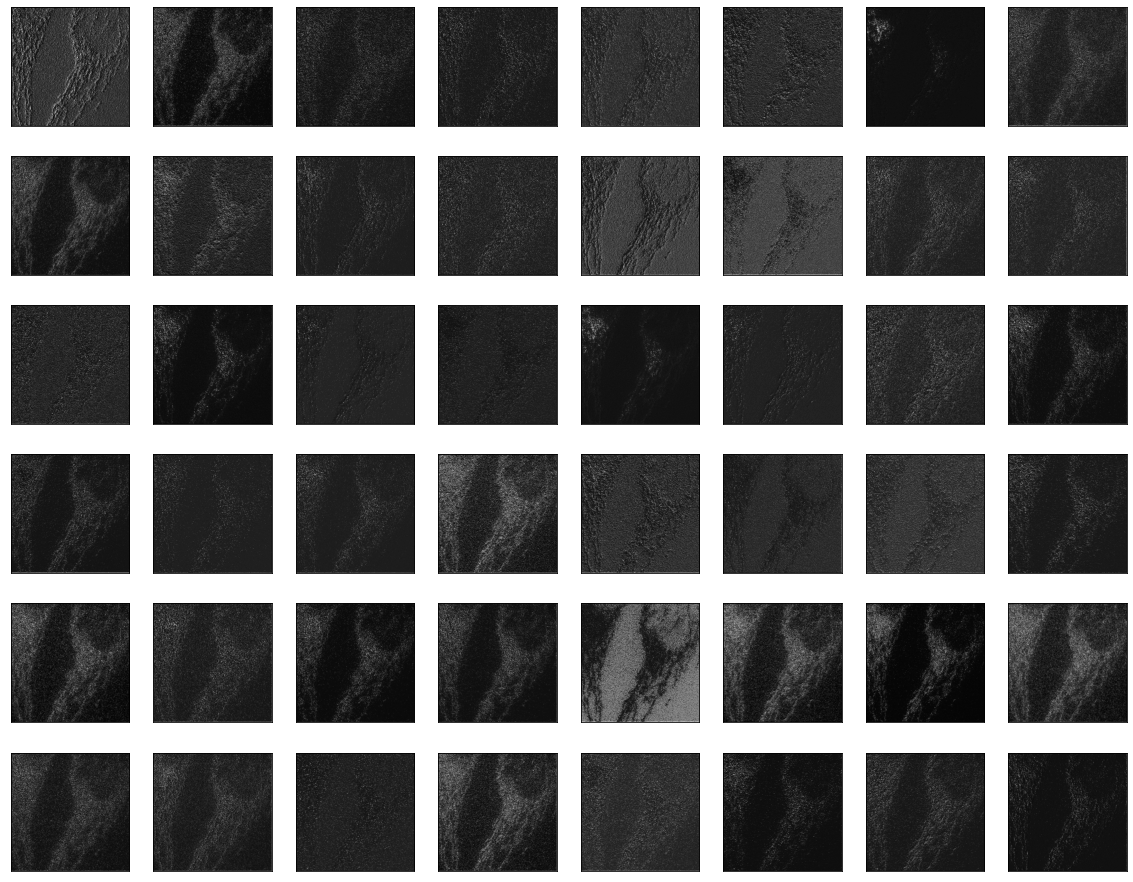

In [39]:
denoised_l1_cpu = denoised_l1.detach().cpu()
denoised_l2_cpu = denoised_l2.detach().cpu()
denoised_l3_cpu = denoised_l3.detach().cpu()
denoised_l4_cpu = denoised_l4.detach().cpu()
denoised_l5_cpu = denoised_l5.detach().cpu()

from matplotlib import pyplot
rows = 6
cols = 8

plt.figure(figsize=(20, 16)) 
ix = 1
for _ in range(rows):
	for _ in range(cols):
		# specify subplot and turn of axis
		ax = pyplot.subplot(rows, cols, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(denoised_l1_cpu[0, ix-1, :, :], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

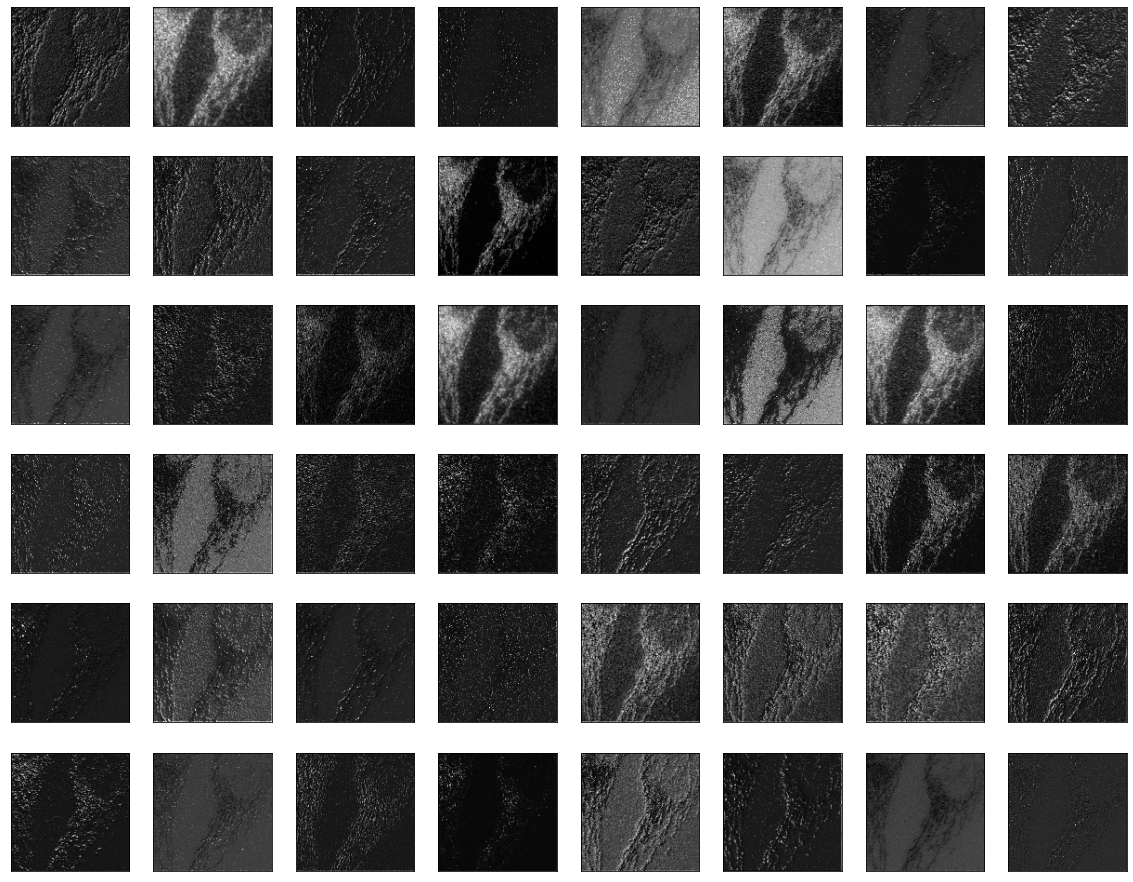

In [40]:
plt.figure(figsize=(20, 16)) 
ix = 1
for _ in range(rows):
	for _ in range(cols):
		# specify subplot and turn of axis
		ax = pyplot.subplot(rows, cols, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(denoised_l2_cpu[0, ix-1, :, :], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

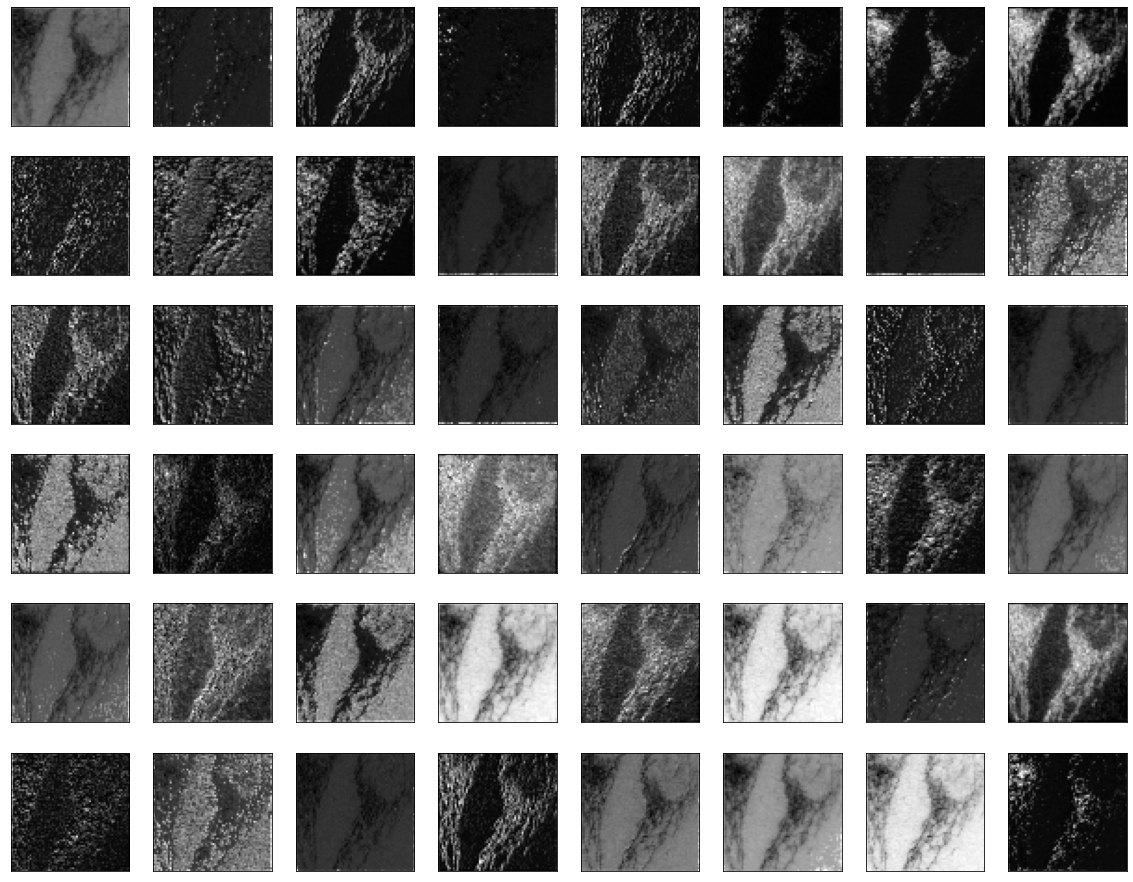

In [42]:
plt.figure(figsize=(20, 16)) 
ix = 1
for _ in range(rows):
	for _ in range(cols):
		# specify subplot and turn of axis
		ax = pyplot.subplot(rows, cols, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(denoised_l3_cpu[0, ix-1, :, :], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

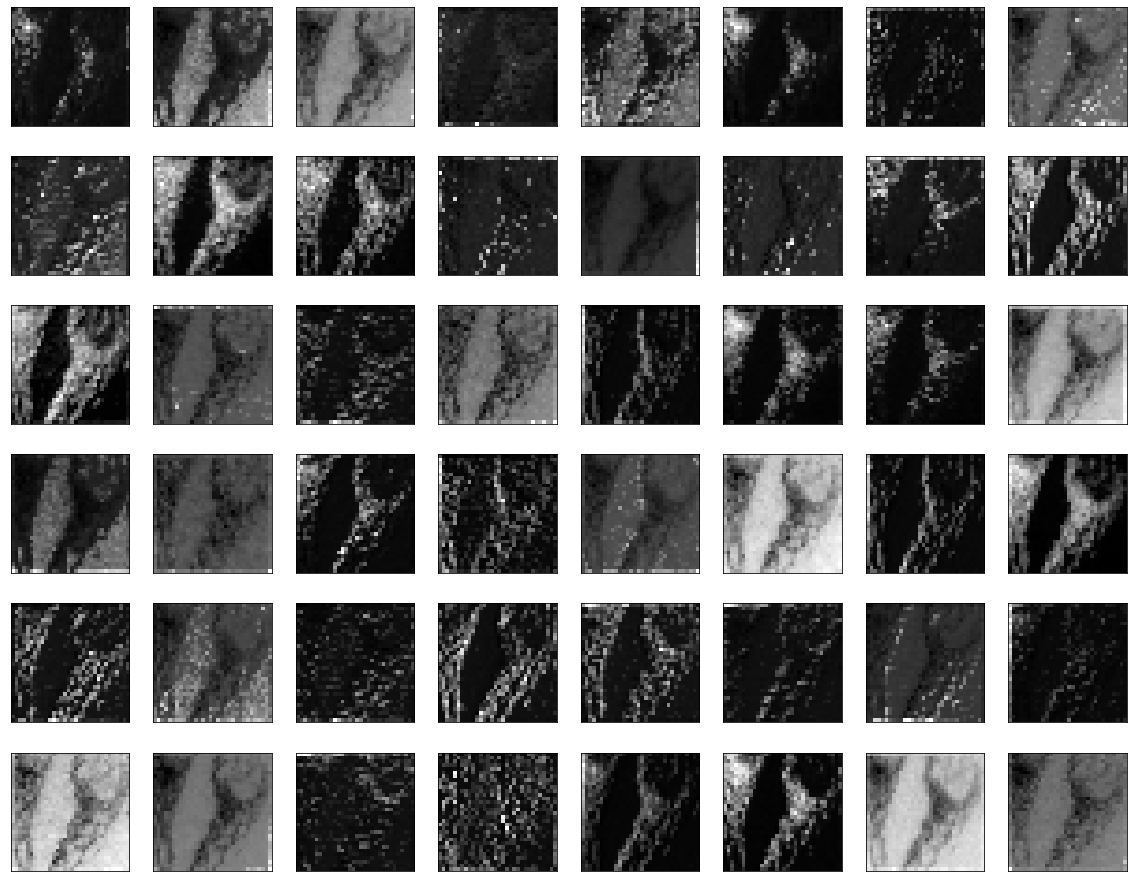

In [43]:
plt.figure(figsize=(20, 16)) 
ix = 1
for _ in range(rows):
	for _ in range(cols):
		# specify subplot and turn of axis
		ax = pyplot.subplot(rows, cols, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(denoised_l4_cpu[0, ix-1, :, :], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

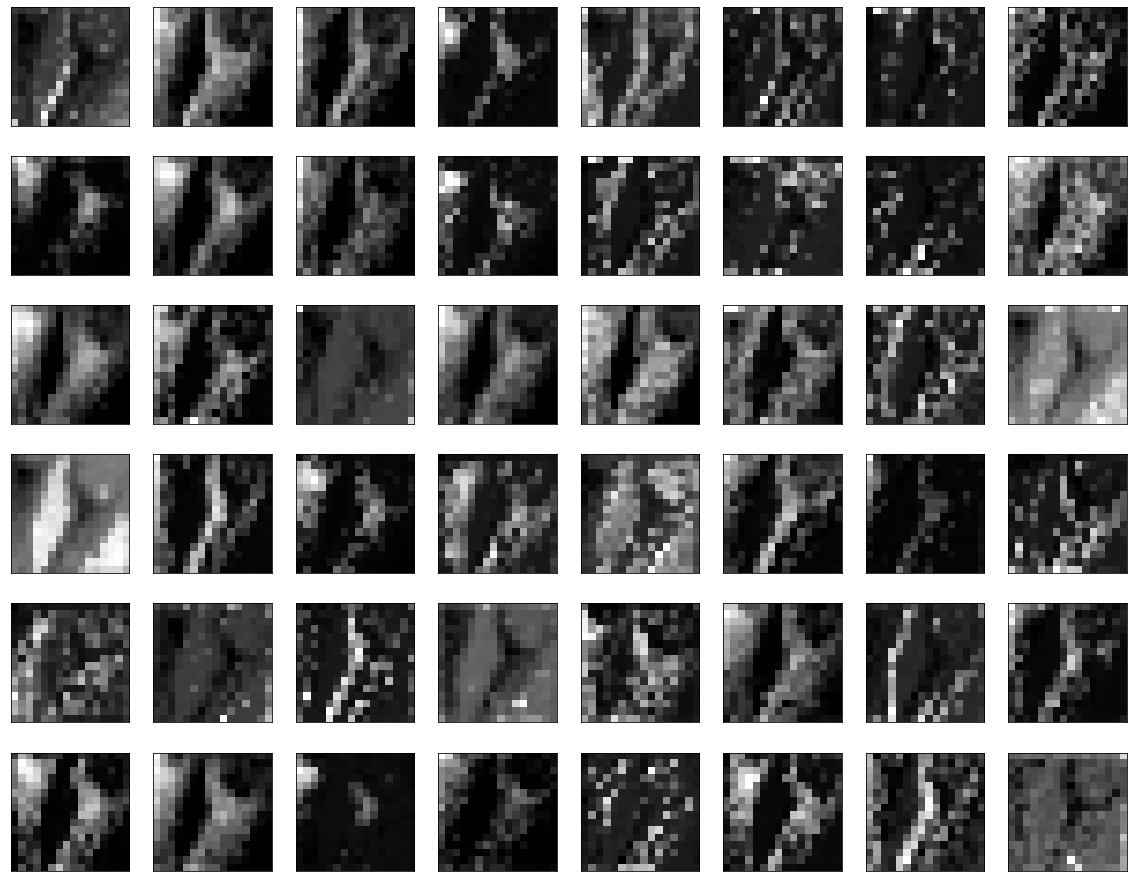

In [44]:
plt.figure(figsize=(20, 16)) 
ix = 1
for _ in range(rows):
	for _ in range(cols):
		# specify subplot and turn of axis
		ax = pyplot.subplot(rows, cols, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(denoised_l5_cpu[0, ix-1, :, :], cmap='gray')
		ix += 1
# show the figure
pyplot.show()